In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load Dataset

In [3]:
df_trn = pd.read_csv('train.csv')
df_tst = pd.read_csv('test.csv')

In [4]:
df_trn.head()

,ID,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,train0001,7.2,0.53,0.14,2.1,0.064,15.0,29.0,0.99323,3.35,0.61,12.1,1
1,train0002,7.2,0.57,0.05,2.3,0.081,16.0,36.0,0.99564,3.38,0.60,10.3,1
2,train0003,8.8,0.61,0.30,2.8,0.088,17.0,46.0,0.99760,3.26,0.51,9.3,0
3,train0004,6.7,0.46,0.24,1.7,0.077,18.0,34.0,0.99480,3.39,0.60,10.6,1
4,train0005,10.5,0.24,0.47,2.1,0.066,6.0,24.0,0.99780,3.15,0.90,11.0,1


In [5]:
df_tst.head()

,ID,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,test0001,10.2,0.40,0.40,2.5,0.068,41.0,54.0,0.99754,3.38,0.86,10.5
1,test0002,6.6,0.44,0.15,2.1,0.076,22.0,53.0,0.99570,3.32,0.62,9.3
2,test0003,11.5,0.30,0.60,2.0,0.067,12.0,27.0,0.99810,3.11,0.97,10.1
3,test0004,11.5,0.35,0.49,3.3,0.070,10.0,37.0,1.00030,3.32,0.91,11.0
4,test0005,6.0,0.58,0.20,2.4,0.075,15.0,50.0,0.99467,3.58,0.67,12.5


# 2. EDA

In [7]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    1119 non-null   object 
 1   fixed acidity         1119 non-null   float64
 2   volatile acidity      1119 non-null   float64
 3   citric acid           1119 non-null   float64
 4   residual sugar        1119 non-null   float64
 5   chlorides             1119 non-null   float64
 6   free sulfur dioxide   1119 non-null   float64
 7   total sulfur dioxide  1119 non-null   float64
 8   density               1119 non-null   float64
 9   pH                    1119 non-null   float64
 10  sulphates             1119 non-null   float64
 11  alcohol               1119 non-null   float64
 12  label                 1119 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 113.8+ KB


In [8]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    480 non-null    object 
 1   fixed acidity         480 non-null    float64
 2   volatile acidity      480 non-null    float64
 3   citric acid           480 non-null    float64
 4   residual sugar        480 non-null    float64
 5   chlorides             480 non-null    float64
 6   free sulfur dioxide   480 non-null    float64
 7   total sulfur dioxide  480 non-null    float64
 8   density               480 non-null    float64
 9   pH                    480 non-null    float64
 10  sulphates             480 non-null    float64
 11  alcohol               480 non-null    float64
dtypes: float64(11), object(1)
memory usage: 45.1+ KB


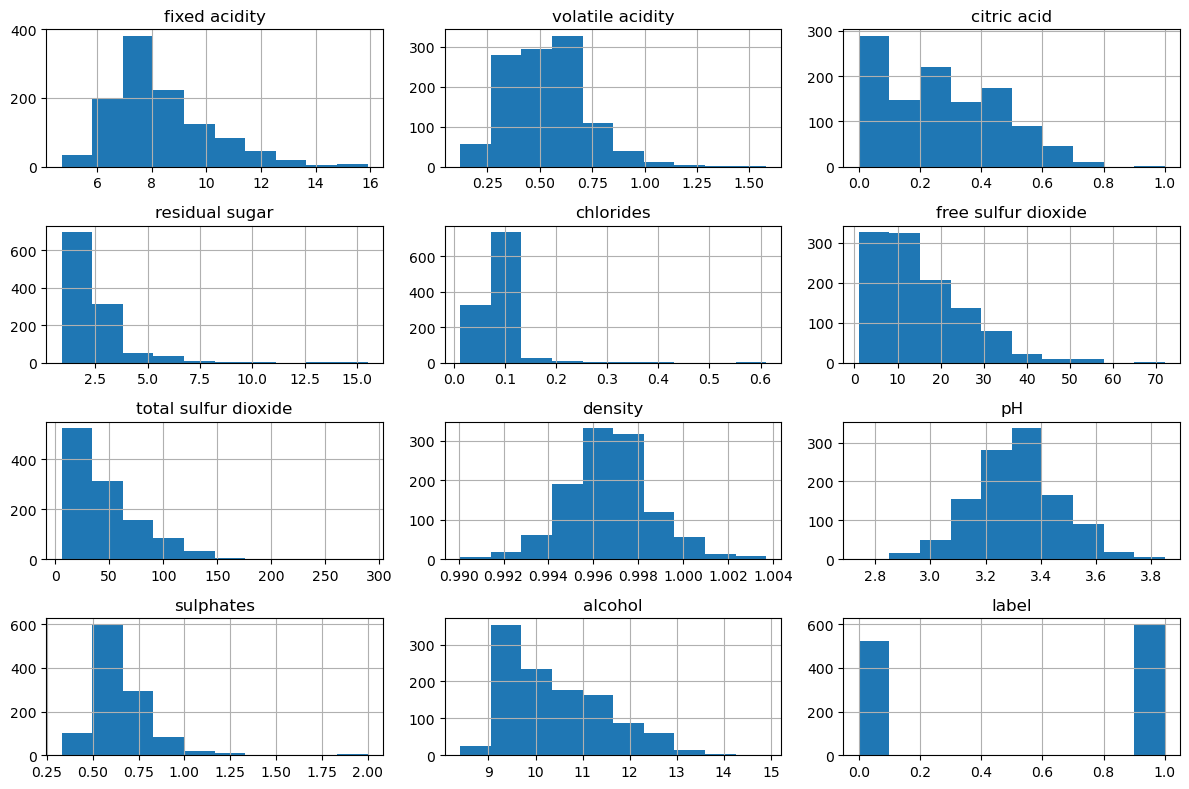

In [9]:
df_trn.hist(figsize=(12,8))
plt.tight_layout()

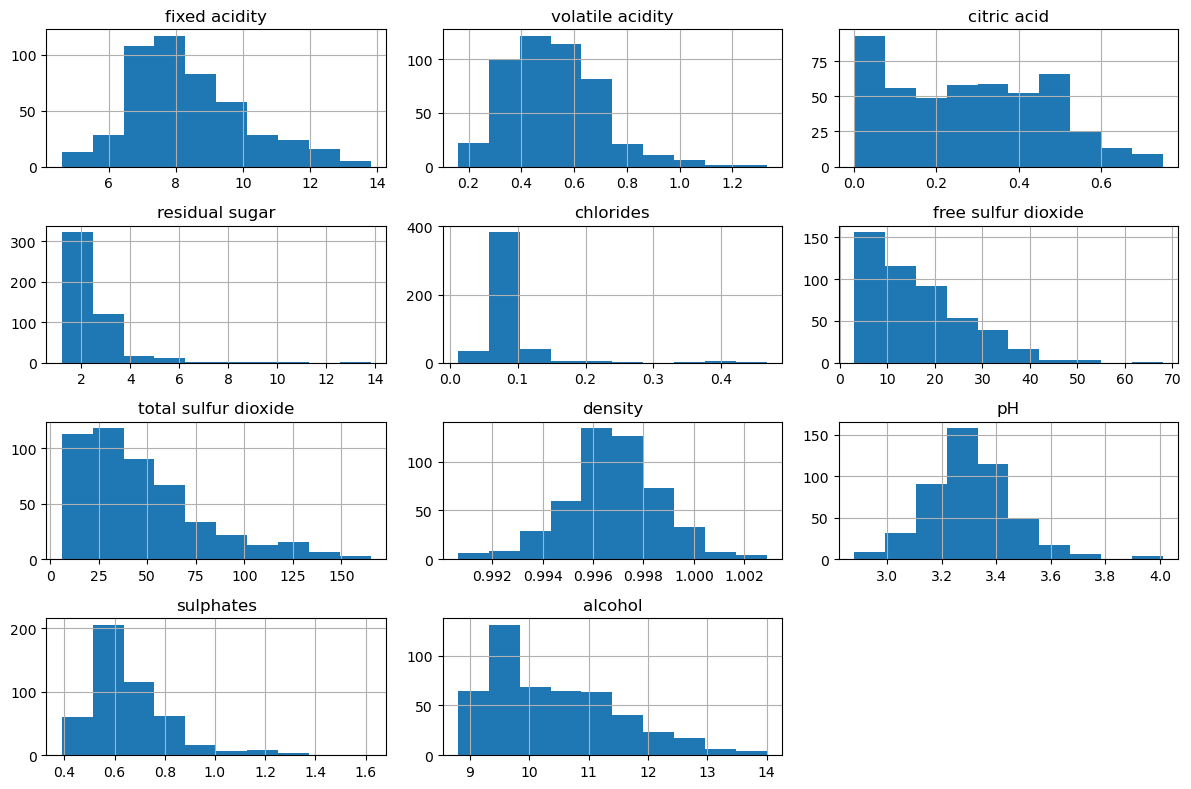

In [10]:
df_tst.hist(figsize=(12,8))
plt.tight_layout()

In [11]:
corr_matrix = df_trn.drop(columns = ['ID']).corr()
corr_matrix['label'].abs().sort_values(ascending = False).head(8)

label                   1.000000
alcohol                 0.432646
volatile acidity        0.322110
total sulfur dioxide    0.231424
sulphates               0.205582
density                 0.159718
citric acid             0.154558
chlorides               0.126220
Name: label, dtype: float64

In [16]:
## 황비율이랑 황산염과 염화율 비율이 중요하다고...??? 왜...?? 몰라...
df_trn['sulfur_ratio'] = df_trn['free sulfur dioxide'] / df_trn['total sulfur dioxide']
df_trn['sulphate_balance'] = df_trn['sulphates'] / df_trn['chlorides']

In [19]:
corr_matrix = df_trn.drop(columns = ['ID']).corr()
corr_matrix['label'].abs().sort_values(ascending = False).head(15)

label                   1.000000
alcohol                 0.432646
sulphate_balance        0.333971
volatile acidity        0.322110
sulfur_ratio            0.234874
total sulfur dioxide    0.231424
sulphates               0.205582
density                 0.159718
citric acid             0.154558
chlorides               0.126220
fixed acidity           0.099300
free sulfur dioxide     0.055060
pH                      0.013660
residual sugar          0.008543
Name: label, dtype: float64

In [20]:
df_tst['sulfur_ratio'] = df_tst['free sulfur dioxide'] / df_tst['total sulfur dioxide']
df_tst['sulphate_balance'] = df_tst['sulphates'] / df_tst['chlorides']

# 3. Preprocessing

In [22]:
id_cols = ['ID']
y_cols = ['label']
num_cols = ['alcohol', 'sulphate_balance', 'volatile acidity', 'sulfur_ratio', 'total sulfur dioxide', 'sulphates', 'density']

In [24]:
X = df_trn[num_cols] 
y = df_trn['label']
X_test = df_tst[num_cols]

In [25]:
Q1 = df_trn[num_cols].quantile(0.25)
Q3 = df_trn[num_cols].quantile(0.75)
IQR = Q3 - Q1

In [34]:
X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y = y[X.index]

# 4. Train model

In [37]:
model = RandomForestClassifier(random_state=42)

In [39]:
model.fit(X, y)

RandomForestClassifier(random_state=42)

# 5. Predict

In [41]:
y_pred = model.predict(X_test)

In [44]:
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,

# 6. 예측 결과를 submission에 넣고 저장하기

In [47]:
submission = pd.DataFrame({
    "ID": df_tst["ID"],     
    "label": y_pred       
})

In [49]:
submission.to_csv("sample_submission1.csv", index=False)